In [1]:
import numpy as np
import pandas as pd
import gurobipy as gp
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

RUNTIME = 600
kfolds = KFold(n_splits=10)
big_m = 100

# Direct Variable Selection – MIQP Problem

General form of Quadratic Optimization problem :

Objective function : $x^{T}Qx + c^{T}x$ <br>
such that <br> 
$ Ax \le b $<br>
$ x \ge 0 $

MIQL implementation has the below decision variables:
1. $m+1$ betas - $ \beta_{0}, \beta_{1} ... \beta_{m}$
2. $m$ variables for variable selection $ z_{1}, z_{2} ... z_{m}$   <br>

Total Constraint equations - 2m +1

Objective function for MIQP : $$ \beta^{T}(X^{T}X)\beta + (-2y^{T}X)\beta$$<br>
such that <br> 
$$ -z_{i}M < \beta_{i} < z_{i}M $$   $\forall  i \in [1,m]$<br>
$$ \sum_{i=1}^m z_{i} \le k$$

Comparing with the quadratic form we have :
$Q =(X^{T}X)$<br>
$c =(-2y^{T}X)$

### Find the best k using MIQP

In [2]:
lasso_d = {}
k_lst = []
sse_lst = []

for k in [5,10,15,20,25,30,35,40,45,50]:
    
    train = pd.read_csv('training_data.csv')
    X = np.array(train.iloc[0:,1:])
    y = np.array(train['y'])
    
    sse = 0
    
    # cross validation
    for train_index, holdout_index in kfolds.split(X):
        X_train, X_holdout = X[train_index], X[holdout_index]
        y_train, y_holdout = y[train_index], y[holdout_index]
        
        n = X_train.shape[0] # number of rows
        m = X_train.shape[1] # number of variables

        # quadratic term Q
        Q = np.zeros((2*m+1, 2*m+1))
        X_Q = np.zeros((n,m+1))
        X_Q[0:n, 0] = 1
        for i in range(n):        
            X_Q[i, 1:] = X_train[i,:]
        Q[:m+1,:m+1] = X_Q.T @ X_Q

        # linear term C
        C = np.zeros(2*m+1)
        C[:m+1] = -2*(y_train.T) @ X_Q
        
        # create A matrix
        A = np.zeros((2*m+1, 2*m+1))

        # big M constraint: weights-M*binary  <= 0
        np.fill_diagonal(A[:m, 1:m+1], 1) 
        np.fill_diagonal(A[:m, m+1:2*m+1], -big_m) 
        
        # big M constraint: weights+M*binary  >= 0
        np.fill_diagonal(A[m:-1, 1:m+1], 1) 
        np.fill_diagonal(A[m:-1, m+1:2*m+1], big_m) 

        # k stocks are chosen
        A[-1, m+1:] = 1

        sense = np.array(['<']*m + ['>']*m + ['<'])

        b = np.concatenate((np.zeros(2*m), [k]))

        lb = np.array([np.NINF]+[-big_m]*m+[np.NINF]*m)

        ndxMod = gp.Model()
        ndxMod_x = ndxMod.addMVar(len(Q),vtype=['C']*(m+1)+['B']*m, lb=lb) 
        ndxMod_con = ndxMod.addMConstrs(A, ndxMod_x, sense, b)
        ndxMod.setMObjective(Q, C, 0, sense=gp.GRB.MINIMIZE)
        ndxMod.Params.OutputFlag = 0
        ndxMod.setParam('TimeLimit', RUNTIME)
        ndxMod.optimize()
        
        # save the coefficients
        coef = ndxMod_x.x[:m+1]
        
        n = X_holdout.shape[0] # number of rows
        
        # X variables for each record in the holdout set
        X_Q = np.zeros((n,m+1))
        X_Q[0:n, 0] = 1
        for i in range(n):        
            X_Q[i, 1:] = X_holdout[i,:]
        
        # calculate the SSE for holdout set
        sse += np.transpose(X_Q @ coef - y_holdout) @ (X_Q @ coef - y_holdout)
        
    print(k,':',sse)
    lasso_d[sse] = k
    
    k_lst.append(k)
    sse_lst.append(sse)
    
best_k = lasso_d[min(k for k, v in lasso_d.items())] # save the best k
print('The best number of X variables is:', best_k)

Academic license - for non-commercial use only - expires 2022-08-24
Using license file C:\Users\chiay\gurobi.lic
5 : 917.4790609380484
10 : 724.7876314288023
15 : 764.0499375891018
20 : 799.0122009667082
25 : 770.482827894026
30 : 830.0824019758022
35 : 831.1040076999241
40 : 847.7662642883423
45 : 847.1084135569309
50 : 847.1845453502016
The best number of X variables is: 10


### Plot the SSE

<function matplotlib.pyplot.show(close=None, block=None)>

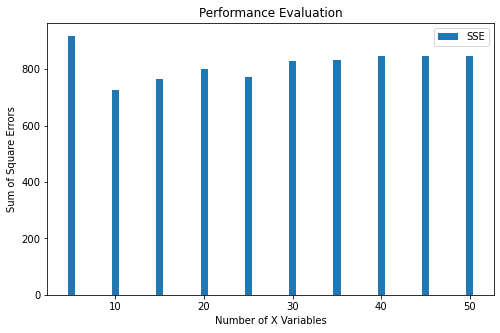

In [3]:
plt.figure(figsize=(8,5))
plt.bar(k_lst, sse_lst, label='SSE')
plt.title('Performance Evaluation')
plt.xlabel('Number of X Variables')
plt.ylabel('Sum of Square Errors')
plt.legend()
plt.show

### Fit the MIQP model on the entire training set with k=10

In [4]:
train = pd.read_csv('training_data.csv')

X_train = np.array(train.iloc[0:,1:])
y_train = np.array(train['y'])

n = X_train.shape[0] # number of rows
m = X_train.shape[1] # number of variables

# quadratic term Q
Q = np.zeros((2*m+1, 2*m+1))
X = np.zeros((n,m+1))
X[0:n, 0] = 1
for i in range(n):        
    X[i, 1:] = X_train[i,:]
Q[:m+1,:m+1] = X.T @ X

# linear term C
C = np.zeros(2*m+1)
C[:m+1] = -2*(y_train.T) @ X

# create A matrix
A = np.zeros((2*m+1, 2*m+1))

# big M constraint: weights-M*binary  <= 0
np.fill_diagonal(A[:m, 1:m+1], 1) 
np.fill_diagonal(A[:m, m+1:2*m+1], -big_m) 
        
# big M constraint: weights+M*binary  >= 0
np.fill_diagonal(A[m:-1, 1:m+1], 1) 
np.fill_diagonal(A[m:-1, m+1:2*m+1], big_m) 

# k stocks are chosen
A[-1, m+1:] = 1

sense = np.array(['<']*m + ['>']*m + ['<'])

b = np.concatenate((np.zeros(2*m), [best_k]))

lb = np.array([-big_m]*(m+1)+[0]*m)

ndxMod = gp.Model()
ndxMod_x = ndxMod.addMVar(len(Q),vtype=['C']*(m+1)+['B']*m, lb=lb) 
ndxMod_con = ndxMod.addMConstrs(A, ndxMod_x, sense, b)
ndxMod.setMObjective(Q, C, 0, sense=gp.GRB.MINIMIZE)
ndxMod.Params.OutputFlag = 0
ndxMod.setParam('TimeLimit', RUNTIME)
ndxMod.optimize()

# save the coefficients
coef = ndxMod_x.x[:m+1]
        
print(coef)

[ 0.97252408  0.          0.          0.          0.          0.
  0.          0.          0.         -2.30820726  0.          0.
  0.          0.          0.         -0.51832612 -0.20416201  0.
  0.          0.          0.          0.          0.         -1.55914318
  0.86697336  0.         -1.31191942  0.          0.          0.
  0.          0.          0.          0.          0.4081653   0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.78147489  0.          0.88738292
 -0.28229213  0.          0.        ]


### Make predictions of y_test using the saved coefficients

In [5]:
test = pd.read_csv('test_data.csv')
X_test = np.array(test.iloc[0:,1:])
y_test = np.array(test['y'])

n = X_test.shape[0] # number of rows
m = X_test.shape[1] # number of variables

# X variables for each record
X = np.zeros((n,m+1))
X[0:n, 0] = 1
for i in range(n):        
    X[i, 1:] = X_test[i,:]
    
X @ coef

array([ 6.17985878,  5.09524299,  3.28559532,  3.75848539, -0.33297526,
       -5.14273683, -3.14454357, -1.23806288,  1.38511093, -0.44173854,
       -1.69500225,  2.73035027,  0.74744903, -0.97192232, -0.68681528,
        8.04522381, -7.94698471,  3.89063974, -4.58142919, -3.21992082,
       -2.16211454,  3.21686318, -3.19810533,  0.19740731, -2.35988844,
       -0.41999885, -1.9125216 , -3.32418587, -3.14170972, -3.55379324,
       -1.80842543, -0.37134301,  1.8670808 ,  5.04927886, -1.80005614,
        3.09427675,  4.38154309,  2.6988627 ,  1.6132886 ,  5.97584637,
       -1.1973583 ,  5.2232542 , -5.84899891, -1.14461528,  4.51802998,
        4.18774866,  4.12046008,  0.61483809,  1.95723246, -1.54904383])

### Calaculate the MSE of y_test

In [6]:
print('The MSE is:', mean_squared_error(y_test, X @ coef))

The MSE is: 2.336543964552524


# Indirect Variable Selection – LASSO

### Fit a linear regression model using Lasso 

In [7]:
train = pd.read_csv('training_data.csv')
X_train = np.array(train.iloc[0:,1:])
y_train = np.array(train['y'])

lasso = linear_model.LassoCV(cv=10).fit(X_train, y_train)

print('Alpha value:', lasso.alpha_)
print('Model intercept:', lasso.intercept_)
print('Total X variables:', (lasso.coef_ != 0).sum())
print('X variable coefficients:', lasso.coef_)

Alpha value: 0.07638765995113514
Model intercept: 1.0015522007348236
Total X variables: 17
X variable coefficients: [-0.         -0.          0.          0.         -0.          0.
 -0.         -0.         -2.16054765  0.         -0.05964031 -0.
 -0.         -0.         -0.41912484 -0.19325408  0.          0.
 -0.          0.          0.         -0.19517759 -1.36388738  0.7425965
 -0.         -1.30481574 -0.          0.          0.05798283  0.
 -0.          0.         -0.09737839  0.28341629  0.          0.
  0.          0.         -0.23157873  0.         -0.          0.
  0.          0.03078191  1.56362172 -0.02160033  0.69992447 -0.09289745
  0.          0.        ]


### Make predictions of y_test

In [8]:
test = pd.read_csv('test_data.csv')
X_test = np.array(test.iloc[0:,1:])
y_test = np.array(test['y'])

lasso.predict(X_test)

array([ 6.07686351,  4.9181073 ,  3.22777954,  3.57138566, -0.41849943,
       -4.94878307, -2.8218873 , -1.49522305,  1.38296395, -0.24746403,
       -1.94701631,  2.70749465,  0.64484559, -0.50918617, -0.31915912,
        7.37584986, -7.54781954,  3.59673093, -4.39624331, -2.98890566,
       -1.94423698,  3.33248953, -2.42122798,  1.13315219, -2.53307168,
       -0.15595162, -1.62271875, -2.31420693, -3.46402012, -3.71707635,
       -1.66827581, -0.07491137,  1.40363987,  5.45269115, -1.20270399,
        2.37325349,  4.74719816,  3.13015173,  1.55100085,  5.85587702,
       -0.81232674,  4.66231732, -5.71548761, -1.20927664,  4.25279319,
        4.09734242,  3.8335482 ,  0.61787077,  1.89407804, -1.02592954])

### Calculate the MSE of y_test

In [9]:
print('The MSE is:', mean_squared_error(y_test, lasso.predict(X_test)))

The MSE is: 2.3496347591605797


### EDA of comparison

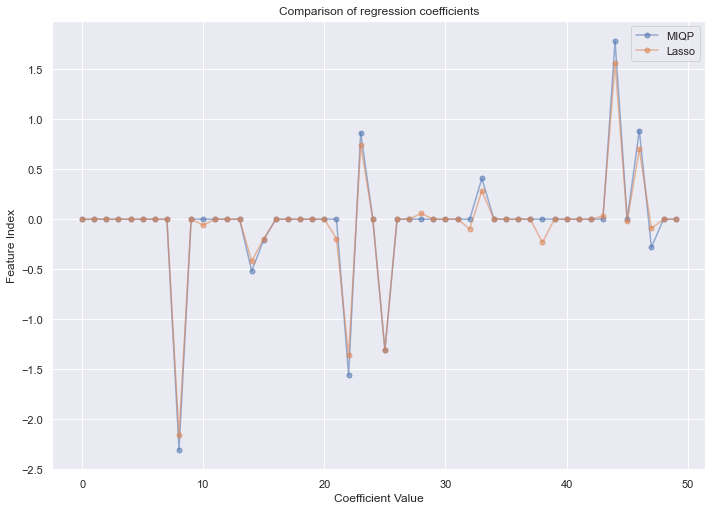

In [76]:
# predictions of y_test

test = pd.read_csv('test_data.csv')
X_test = np.array(test.iloc[0:,1:])
y_test = np.array(test['y'])

#lasso.predict(X_test)

sns.kdeplot(X@coef,alpha=0.35,fill='orange',label='MIQP',legend=True)
sns.kdeplot(lasso.predict(X_test),alpha=0.35,fill='skyblue',label='Lasso',legend=True)
plt.legend()
plt.xlabel('Prediction')plt.plot(coef[1:],alpha=0.55,label='MIQP',marker='.', markersize=10) 
plt.plot(lasso.coef_,alpha=0.55,label='Lasso',marker='.', markersize=10) #lets plot the second line
plt.ylabel('Feature Index')
plt.xlabel('Coefficient Value')
plt.title('Comparison of regression coefficients')
plt.legend(loc = 'best')
plt.show()

Text(0.5, 0, 'Prediction')

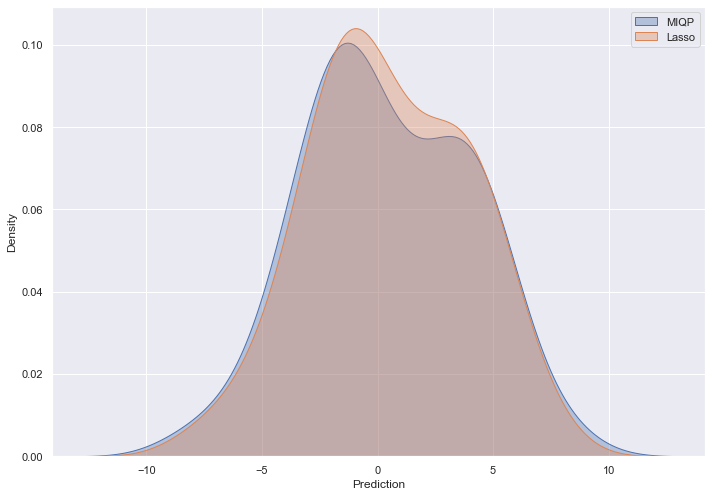

In [100]:
sns.kdeplot(X@coef,alpha=0.35,fill='orange',label='MIQP',legend=True)
sns.kdeplot(lasso.predict(X_test),alpha=0.35,fill='skyblue',label='Lasso',legend=True)
plt.legend()
plt.xlabel('Prediction')